In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,precision_recall_curve
import statsmodels.formula.api as sm
from xgboost import XGBClassifier
import datetime
from datetime import *
import lightgbm as lgbm
from sklearn.metrics import log_loss
import optuna

In [133]:
df = pd.read_csv("C:\\Users\\yashs\\OneDrive\\Desktop\\Kaggle\\LightGBM\\train.csv")

In [134]:
clf = lgbm.LGBMClassifier(objective='binary')

In [135]:
df.shape

(300000, 32)

In [136]:
X=df.drop("target",axis=1)
Y=df["target"]

In [137]:
cat_col = list(X.select_dtypes(include=["O"]).columns)

In [138]:
X_enc = pd.get_dummies(data=X,columns=cat_col,drop_first=True)

In [139]:
Y.value_counts(1)

0    0.73513
1    0.26487
Name: target, dtype: float64

In [140]:
X_train,X_test,Y_train,Y_test=train_test_split(X_enc,Y,test_size=0.3,random_state=1,stratify=Y)

In [141]:
clf.fit(X_train,Y_train)

LGBMClassifier(objective='binary')

In [142]:
def out_pred(X_train,X_test,model):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    return train_pred,test_pred

In [143]:
train_pred,test_pred=out_pred(X_train,X_test,clf)

In [144]:
def out_pred_proba(X_train,X_test,model):
    train_pred_proba = model.predict_proba(X_train)
    test_pred_proba = model.predict_proba(X_test)
    return train_pred_proba,test_pred_proba

In [145]:
train_pred_proba,test_pred_proba = out_pred_proba(X_train,X_test,clf)

In [146]:
def plot_confusion_matrix(y_true,y_pred,Train,Test):
    if Train=='Yes':
        sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt="d",cbar=False,cmap="YlGnBu")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Training data confusion matrix")
        df_cm = pd.DataFrame(data=confusion_matrix(y_true,y_pred),columns = ["Predicted : 0","Predicted : 1"],index=["Actual : 0","Actual : 1"])
        return df_cm
    else:
        sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt="d",cbar=False,cmap="YlGnBu")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Testing data confusion matrix")
        df_cm = pd.DataFrame(data=confusion_matrix(y_true,y_pred),columns = ["Predicted : 0","Predicted : 1"],index=["Actual : 0","Actual : 1"])
        return df_cm

,Predicted : 0,Predicted : 1
Actual : 0,144068,10309
Actual : 1,20731,34892


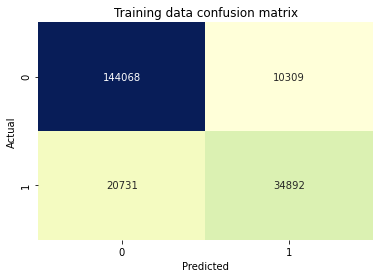

In [147]:
plot_confusion_matrix(Y_train,train_pred,'Yes',None)

In [148]:
print(classification_report(Y_train,train_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90    154377
           1       0.77      0.63      0.69     55623

    accuracy                           0.85    210000
   macro avg       0.82      0.78      0.80    210000
weighted avg       0.85      0.85      0.85    210000



,Predicted : 0,Predicted : 1
Actual : 0,61584,4578
Actual : 1,9108,14730


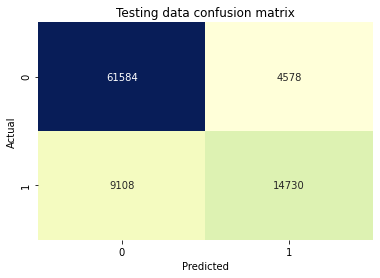

In [149]:
plot_confusion_matrix(Y_test,test_pred,None,'Yes')

In [150]:
print(classification_report(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     66162
           1       0.76      0.62      0.68     23838

    accuracy                           0.85     90000
   macro avg       0.82      0.77      0.79     90000
weighted avg       0.84      0.85      0.84     90000



### Handling categorical variables with LightGBM. Here I will not be encoding the variables

In [151]:
cat_features = X.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_features]

In [152]:
cat_idx

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [153]:
for col in cat_features:
    X[col]=pd.Categorical(X[col])

In [154]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=1,stratify=Y)

In [155]:
clf = lgbm.LGBMClassifier()

In [156]:
a=clf.fit(X_train,Y_train,categorical_feature=cat_idx)

In [157]:
train_pred,test_pred=out_pred(X_train,X_test,clf)

In [158]:
train_prob,test_prob=out_pred_proba(X_train,X_test,clf)

,Predicted : 0,Predicted : 1
Actual : 0,61560,9092
Actual : 1,4602,14746


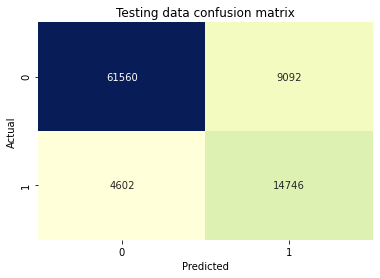

In [159]:
plot_confusion_matrix(test_pred,Y_test,None,'Yes')

In [160]:
print(classification_report(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     66162
           1       0.76      0.62      0.68     23838

    accuracy                           0.85     90000
   macro avg       0.82      0.77      0.79     90000
weighted avg       0.84      0.85      0.84     90000



In [161]:
from sklearn.metrics import recall_score

In [162]:
recall_score(Y_test,test_pred)

0.6185921637721286

### CV in LightGBM

In [163]:
X=df.drop("target",axis=1)
Y=df["target"]

In [164]:
for col in cat_features:
    X[col]=pd.Categorical(X[col])

In [165]:
from sklearn.model_selection import StratifiedKFold

In [166]:
skf = StratifiedKFold(n_splits=10)

In [167]:
import time

In [168]:
scores=[]
for idx,(train_idx,test_idx) in enumerate(skf.split(X,Y)):
    print("="*12+"Training fold {}".format(idx)+"="*12)
    X_train,X_test = X.iloc[train_idx],X.iloc[test_idx]
    Y_train,Y_test = Y[train_idx],Y[test_idx]
    start = datetime.now()
    clf = lgbm.LGBMClassifier()
    clf.fit(X_train,Y_train,categorical_feature=cat_features,eval_set=[(X_test,Y_test)],eval_metric="binary_logloss",
            early_stopping_rounds=200,verbose=False)
    preds = clf.predict_proba(X_test)
    loss = log_loss(Y_test, preds)
    #scores[idx] = loss
    runtime = datetime.now() - start
    print("Fold {} finished with score: {} in {} seconds.\n".format(idx,np.round(loss,5),np.round(runtime.total_seconds(),2)))

============Training fold 0============
Fold 0 finished with score: 0.3481 in 3.51 seconds.

============Training fold 1============
Fold 1 finished with score: 0.34762 in 3.68 seconds.

============Training fold 2============
Fold 2 finished with score: 0.34815 in 3.32 seconds.

============Training fold 3============
Fold 3 finished with score: 0.3494 in 3.28 seconds.

============Training fold 4============
Fold 4 finished with score: 0.34703 in 3.26 seconds.

============Training fold 5============
Fold 5 finished with score: 0.34979 in 3.59 seconds.

============Training fold 6============
Fold 6 finished with score: 0.35376 in 3.32 seconds.

============Training fold 7============
Fold 7 finished with score: 0.35041 in 3.18 seconds.

============Training fold 8============
Fold 8 finished with score: 0.34665 in 3.82 seconds.

============Training fold 9============
Fold 9 finished with score: 0.35193 in 5.2 seconds.



### Hyperparameter tuning

In [169]:
from sklearn.metrics import recall_score

In [170]:
from optuna.integration import LightGBMPruningCallback

In [171]:
clf=lgbm.LGBMClassifier()

In [197]:
def objective(trial):
    n_estimators=trial.suggest_int("n_estimators",100,5000,step=1)
    learning_rate=trial.suggest_float("learning_rate",1e-7,0.3,log=True)
    max_depth=trial.suggest_int("max_depth",3,12,step=1)
    num_leaves=trial.suggest_int("num_leaves",20,4000,log=True)
    min_child_weight=trial.suggest_int("min_child_weight",20,10000,step=100)
    min_split_gain=trial.suggest_float("min_split_gain",0,15)
    subsample=trial.suggest_float("subsample",0.2,0.95,step=0.1)
    colsample_bytree=trial.suggest_float("colsample_bytree",0.2,0.95,step=0.1)
    reg_alpha=trial.suggest_int("reg_alpha",0,100,step=1)
    reg_lambda=trial.suggest_int("reg_lambda",0,100,step=1)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    cv_scores=np.empty(10)
    def calculate_recall(y_true, p_pred_1):
        y_pred=[]
        if p_pred_1>=0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
        c_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        TN = c_matrix[0,0]
        FN = c_matrix[1,0]
        FP = c_matrix[0,1]
        TP = c_matrix[1,1]
        recall = TP / (TP + FN)
        return ('recall', recall, True)
    for idx,(train_idx,test_idx) in enumerate(cv.split(X,Y)):
        X_train,X_test=X.iloc[train_idx],X.iloc[test_idx]
        Y_train,Y_test=Y.iloc[train_idx],Y.iloc[test_idx]
        clf=lgbm.LGBMClassifier(objective='binary',n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,
                               num_leaves=num_leaves,min_child_weight=min_child_weight,min_split_gain=min_split_gain,
                               subsample=subsample,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha,
                               reg_lambda=reg_lambda,is_unbalance=True)
        clf.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100,eval_metric="auc",
               callbacks=[LightGBMPruningCallback(trial,"auc")],categorical_feature=cat_idx,verbose=False)
        #clf.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100,eval_metric='recall_score',verbose=False)
        preds=clf.predict(X_test)
        cv_scores[idx]=recall_score(Y_test,preds)
    return np.mean(cv_scores)

In [198]:
study = optuna.create_study(direction='maximize',study_name='Recall-maximium')

[I 2022-08-07 02:04:00,692] A new study created in memory with name: Recall-maximium


In [199]:
study.optimize(objective,n_trials=10)

[I 2022-08-07 02:09:06,740] Trial 0 finished with value: 0.14783869228529517 and parameters: {'n_estimators': 4285, 'learning_rate': 0.00047234047889840484, 'max_depth': 11, 'num_leaves': 170, 'min_child_weight': 4320, 'min_split_gain': 7.556165827562945, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'reg_alpha': 99, 'reg_lambda': 57}. Best is trial 0 with value: 0.14783869228529517.
[I 2022-08-07 02:19:36,411] Trial 1 finished with value: 0.7585356941410644 and parameters: {'n_estimators': 2414, 'learning_rate': 0.001295369448057127, 'max_depth': 5, 'num_leaves': 3954, 'min_child_weight': 8120, 'min_split_gain': 7.012692048889495, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'reg_alpha': 86, 'reg_lambda': 97}. Best is trial 1 with value: 0.7585356941410644.
[I 2022-08-07 02:20:30,575] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 3271, 'learning_rate': 0.0002203852826521712, 'max_depth': 4, 'num_leaves': 3567, 'min_child_weight': 9820, 'mi

In [200]:
study.best_value

0.7916966721165022

### Plotting importance

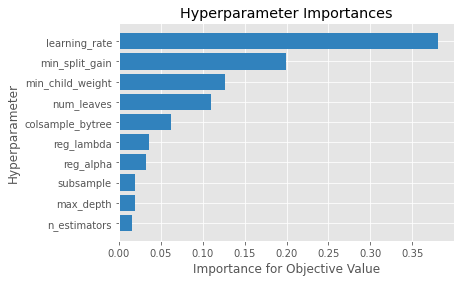

In [201]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);